In [1]:
# MISC
import os
import sys

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

# import shutup
# shutup.please()

import jax
import jax.numpy as jnp

import numpy as np
from functools import partial

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

from utils.datasets import GCDataset
from agents.dynamics_aware_iql import GCIQLAgent
from hydra import initialize, compose
from omegaconf import OmegaConf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-notebook'])

GLOBAL_KEY = jax.random.key(42)

In [ ]:
import matplotlib.pyplot as plt

plt.cm.tab20c.colors[4],
# plt.cm.tab20c.colors[5],
# plt.cm.tab20c.colors[-4],
# plt.cm.tab20c.colors[-3],
# plt.cm.tab20c.colors[-2]

(0.7411764705882353, 0.7411764705882353, 0.7411764705882353)

# Genie

Total trajectories: 8000
Trajectories with hints: 7515
Trajectories without hints: 485
Box 0 revealed: 5831
Box 1 revealed: 820
Box 2 revealed: 864


{
│   'actions': (8000, 100, 1),
│   'item_locations': (8000, 100),
│   'masks': (8000, 100),
│   'next_observations': (8000, 100, 192),
│   'next_states': (8000, 100, 192),
│   'observations': (8000, 100, 192),
│   'rewards': (8000, 100),
│   'states': (8000, 100, 192)
}

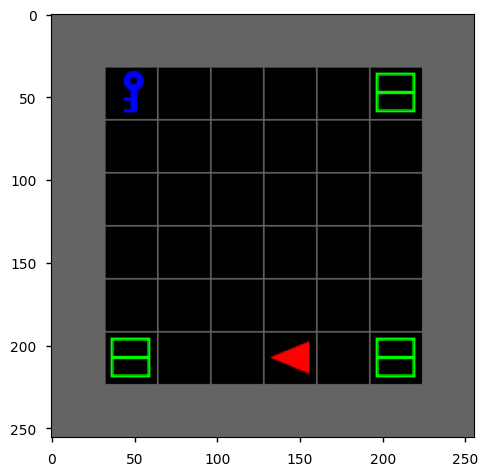

In [2]:
from envs.new_minigrid.genie import Genie
import gymnasium as gym
from envs.minigrid.env_utils import convert_trajs_to_dict

env = gym.make("MiniGrid-Genie-8x8-v0", disable_env_checker=True)
env = env.unwrapped
env.seed(seed=228)
obs, _ = env.reset()
plt.imshow(env.render())

# # collect data
whole_data = np.load("/home/m_bobrin/ZeroShotRL/envs/new_minigrid/collect_MiniGrid-Genie-8x8.npz", allow_pickle=True)['arr_0'][()]

def classify_trajectories(observations):
    num_episodes = observations.shape[0]
    episode_length = observations.shape[1]
    sphinx_pos = [1, 1]
    
    revealed_indices = []
    no_hint_indices = []
    box_revealed = {0: [], 1: [], 2: []}
    
    for ep_idx in range(num_episodes):
        revealed_box = None
        
        for t in range(episode_length):
            hint_value = observations[ep_idx, t, sphinx_pos[0], sphinx_pos[1], 1]
            
            if hint_value < 3:
                revealed_box = int(hint_value)
                break  # Stop at first hint
        
        if revealed_box is not None:
            revealed_indices.append(ep_idx)
            box_revealed[revealed_box].append(ep_idx)
        else:
            no_hint_indices.append(ep_idx)
    
    return revealed_indices, no_hint_indices, box_revealed

# Classify all trajectories
revealed_indices, no_hint_indices, box_revealed = classify_trajectories(whole_data['observations'])

# Print statistics
print(f"Total trajectories: {len(whole_data['observations'])}")
print(f"Trajectories with hints: {len(revealed_indices)}")
print(f"Trajectories without hints: {len(no_hint_indices)}")
print(f"Box 0 revealed: {len(box_revealed[0])}")
print(f"Box 1 revealed: {len(box_revealed[1])}")
print(f"Box 2 revealed: {len(box_revealed[2])}")

revealed_obs = {k: whole_data['observations'][v].reshape(-1, 100, 192) for k, v in box_revealed.items()}
revealed_actions = {k: whole_data['actions'][v].reshape(-1, 100, 1) for k, v in box_revealed.items()}
revealed_next_obs = {k: whole_data['next_observations'][v].reshape(-1, 100, 192) for k, v in box_revealed.items()}
no_hint_trajs_obs = whole_data['observations'][no_hint_indices].reshape(-1, 100, 192)
no_hint_trajs_acts = whole_data['actions'][no_hint_indices].reshape(-1, 100, 1)
no_hint_trajs_next_obs = whole_data['next_observations'][no_hint_indices].reshape(-1, 100, 192)

whole_data['observations'] = whole_data['observations'].reshape(-1, 100, 192)
whole_data['next_observations'] = whole_data['next_observations'].reshape(-1, 100, 192)
whole_data['states'] = whole_data['states'].reshape(-1, 100, 192)
whole_data['next_states'] = whole_data['states'].reshape(-1, 100, 192)
whole_data['actions'] = whole_data['actions'][...,None]


pprint(jax.tree.map(lambda x: x.shape, whole_data))

In [4]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction, LinearProbing
from utils.flax_utils import TrainState, ModuleDict
import optax
from utils.datasets import Dataset
from sklearn.manifold import TSNE
from utils.networks import MLP

whole_dataset = Dataset.create(**jax.device_get(whole_data))
example_batch = whole_dataset.sample(1)

# Networks
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
dynamics_def = DynamicsTransformer(
    num_layers=4,
    num_heads=4,
    out_dim=64,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=96,
    mlp_dim=128,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=example_batch['observations'].shape[1]
)
linear_prob_def = LinearProbing(hidden_dims=(32, 32, 32), out_dim=3)

# Optimization
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0), optax.adam(learning_rate=3e-4))
network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                    example_batch['observations'], True))
            )
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'],
                                           jnp.zeros((1, example_batch['observations'].shape[1], dynamics_def.out_dim))))
)
network_info.update(
    linear_probing=(linear_prob_def, (jnp.zeros((1, dynamics_def.out_dim))))
)
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

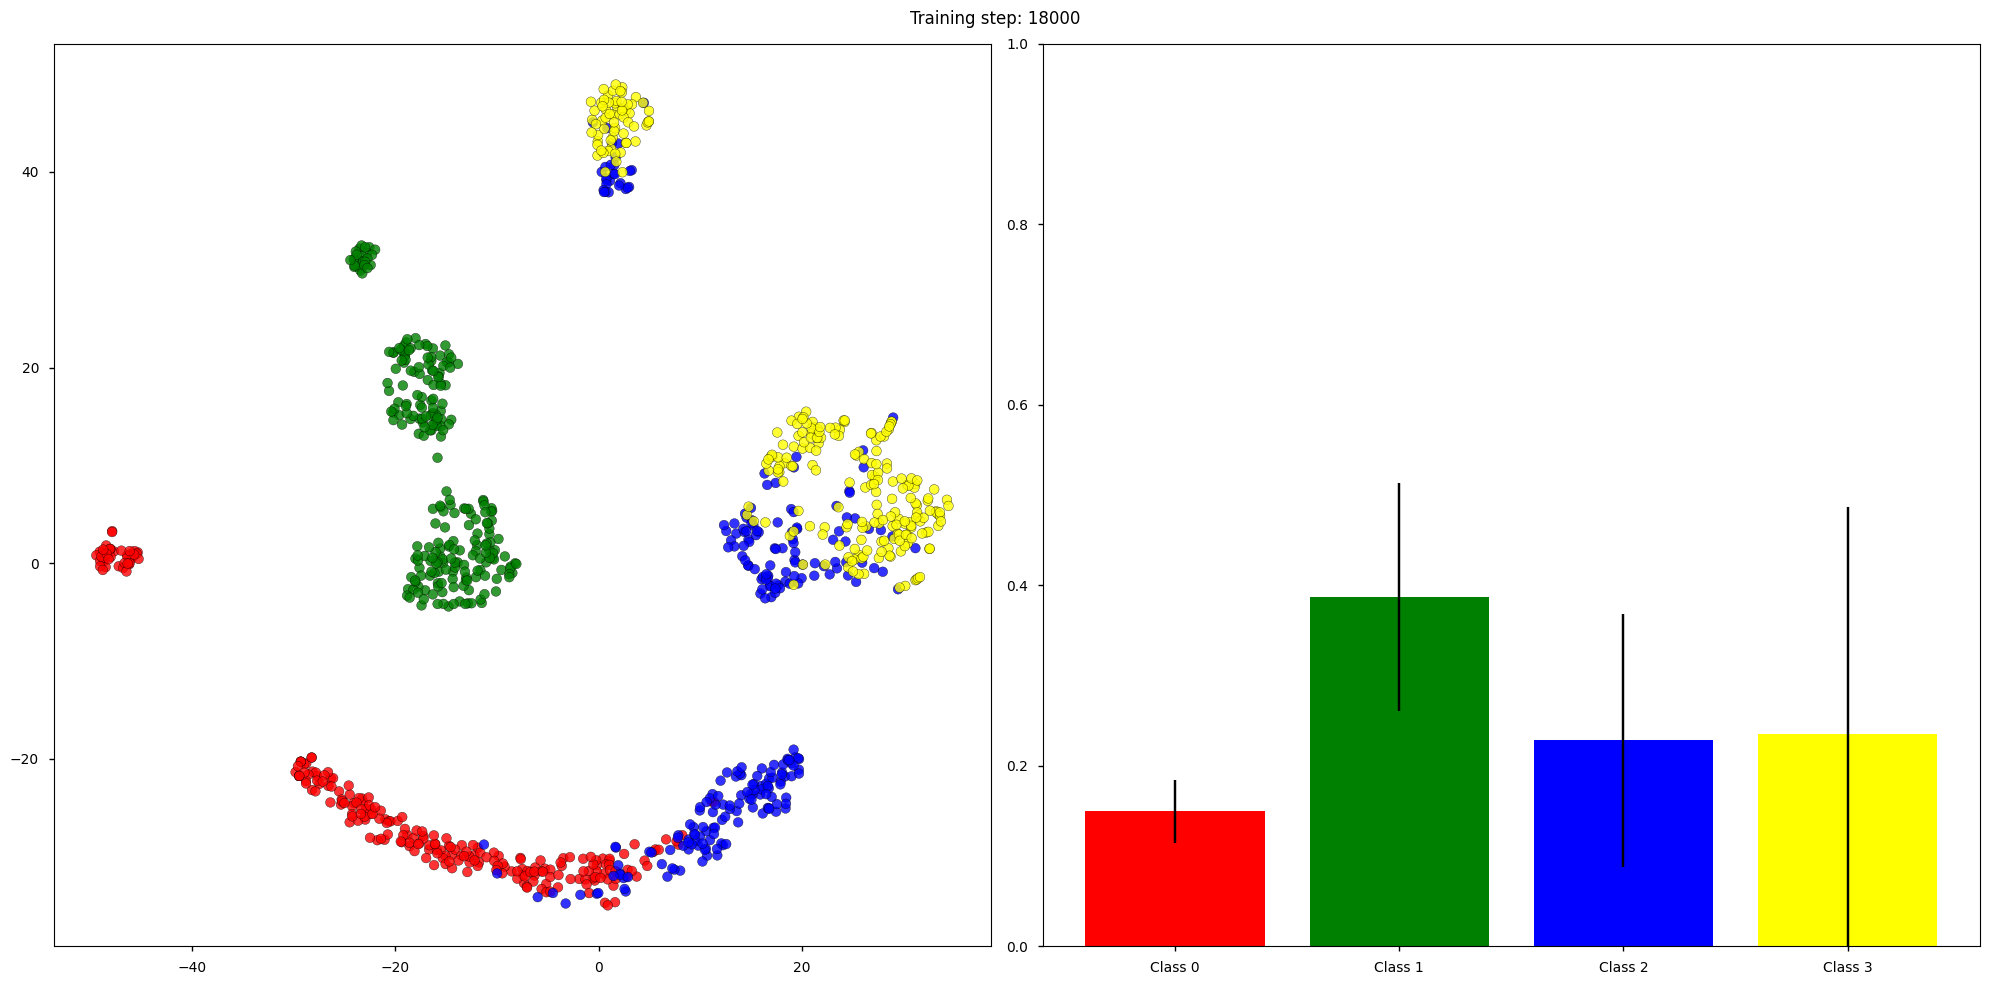

In [ ]:
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

def trans_encoder(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_log_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_log_std)
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    return loss, {"context_embedding_loss": loss}

@jax.jit
def update_belief_encoder(agent, batch, rng):
    def loss_fn(grad_params):
        return trans_encoder(agent, batch, grad_params, rng)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

def linear_probing_loss(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_log_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=False)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_log_std)
    belief_preds = agent.select("linear_probing")(dynamics_embedding, params=grad_params)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(belief_preds, batch['labels']).mean()
    return loss, {'probing_loss': loss}

@jax.jit
def update_linear_probing(agent, batch, rng):
    def loss_fn(grad_params):
        return linear_probing_loss(agent, batch, grad_params, rng)
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

box0_obs = revealed_obs[0][:256]
box_0_acts = revealed_actions[0][:256]
box0_nobs = revealed_next_obs[0][:256]

box1_obs = revealed_obs[1][:256]
box_1_acts = revealed_actions[1][:256]
box1_nobs = revealed_next_obs[1][:256]

box2_obs = revealed_obs[2][:256]
box_2_acts = revealed_actions[2][:256]
box2_nobs = revealed_next_obs[2][:256]

no_hint_trajs_obs = no_hint_trajs_obs[:256]
no_hint_trajs_next_obs = no_hint_trajs_next_obs[:256]
no_hint_trajs_acts = no_hint_trajs_acts[:256]

all_boxes_obs = np.concatenate([box0_obs, box1_obs, box2_obs, no_hint_trajs_obs])
all_boxes_actions = np.concatenate([box_0_acts, box_1_acts, box_2_acts, no_hint_trajs_acts])
all_boxes_nobs = np.concatenate([box0_nobs, box1_nobs, box2_nobs, no_hint_trajs_next_obs])
colors = ['red'] * 256 + ['green'] * 256 + ['blue'] * 256 + ['yellow'] * 256
labels = np.array([0] * 100 + [1] * 256 + [2] * 150 + [3] * 163)

train_indices, test_indices = train_test_split(
    np.arange(labels.shape[0]),
    test_size=0.4,
    random_state=42,
    stratify=labels
)

# FOR PROBING TAKE TEST CLASS
rand_box_obs_2 = revealed_obs[2][:256]
rand_box_nobs_2 = revealed_next_obs[2][:256]
rand_box_actions_2 = revealed_actions[2][:256]

pbar = tqdm(range(50_000))
for i in pbar:
    batch = whole_dataset.sample(512)
    update_key = jax.random.fold_in(GLOBAL_KEY, i)
    network, info = update_belief_encoder(network, batch, update_key)
    
    # if i % 500 == 0:
        
        # rand_key = jax.random.fold_in(GLOBAL_KEY, i)
        # key, update_key = jax.random.split(rand_key, 2)
        # sample_idx = np.random.randint(low=0, high=3)
        # rand_box_obs = revealed_obs[sample_idx][:256]
        # rand_box_nobs = revealed_next_obs[sample_idx][:256]
        # rand_box_actions = revealed_actions[sample_idx][:256]
        # batch = {
        #     "observations": rand_box_obs,
        #     "next_observations": rand_box_nobs,
        #     "actions": rand_box_actions,
        #     "labels": jnp.tile(sample_idx, reps=(rand_box_obs.shape[0], ))
        # }
        # network, info = update_linear_probing(network, batch, update_key)
            
    if i % 1000 == 0:
        clear_output()
        dynamics_embedding_mean, std = network.select('dynamic_transformer')(all_boxes_obs, all_boxes_actions,
                                                                            all_boxes_nobs, train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
        
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
        axs[0].scatter(tsne[:, 0], tsne[:, 1], 
                    edgecolors='black',
                    c=colors,
                    alpha=0.8)
        
        # dynamics_embedding_mean, dynamics_embedding_log_std = network.select('dynamic_transformer')(rand_box_obs_2, rand_box_actions_2,
        #                                                                     rand_box_nobs_2, train=False)
        # dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_log_std)
        logistic_reg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=500).fit(dynamics_embedding[train_indices], labels[train_indices])
        belief_preds = logistic_reg.predict_proba(dynamics_embedding[test_indices])
        # linear_reg = LinearRegression().fit(dynamics_embedding[train_indices], labels[train_indices])
        # belief_preds = linear_reg.predict(dynamics_embedding[test_indices])
        # # belief_preds = jax.nn.softmax(network.select("linear_probing")(dynamics_embedding), -1)
        mean_probs = belief_preds.mean(axis=0)
        std_probs = belief_preds.std(axis=0)

        axs[1].bar(range(4), mean_probs, yerr=std_probs, 
                color=['red', 'green', 'blue', 'yellow'], capsize=5)
        axs[1].set_xticks(range(4), [f'Class {i}' for i in range(4)])
        axs[1].set_ylim(0, 1)
        
        fig.suptitle(f"Training step: {i}")
        plt.tight_layout()
        display(fig)
        plt.close(fig)

In [ ]:
# # Learn probing 

# pbar = tqdm(range(10_000))
# for i in pbar:
#     rand_key = jax.random.fold_in(GLOBAL_KEY, i)
#     key, update_key = jax.random.split(rand_key, 2)
#     sample_idx = np.random.randint(low=0, high=3)
#     rand_box_obs = revealed_obs[sample_idx][:256]
#     rand_box_nobs = revealed_next_obs[sample_idx][:256]
#     rand_box_actions = revealed_actions[sample_idx][:256]
#     batch = {
#         "observations": rand_box_obs,
#         "next_observations": rand_box_nobs,
#         "actions": rand_box_actions,
#         "labels": jnp.tile(sample_idx, reps=(rand_box_obs.shape[0], ))
#     }
#     network, info = update_linear_probing(network, batch, update_key)
    

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [26]:
item_locations = []

all_obses = []
all_actions = []
all_next_obses = []

renders = []
for i in range(1):
    renders = []
    obs, _ = env.reset()
    reward=0
    done = False
    obses = []
    actions = []
    next_obses = []
    item_locations.append(env.item_location)
    step = 0
    while step < 100:
        step += 1
        obses.append(obs['image'].reshape(-1))
        action = env.action_space.sample()
        actions.append(action[None])
        obs, rew, done, _ = env.step(action)
        next_obses.append(obs['image'].reshape(-1))
        renders.append(env.render())
    all_obses.append(np.stack(obses))
    all_actions.append(np.stack(actions))
    all_next_obses.append(np.stack(next_obses))
    
obses = np.stack(all_obses)
actions = np.stack(all_actions)
next_obses = np.stack(all_next_obses)

In [28]:
mediapy.show_video(
    renders
)

In [ ]:
box_inf_test_obs = revealed_obs[1][:256]
box_inf_test_acts = revealed_actions[1][:256]
box_inf_test_nobs = revealed_next_obs[1][:256]

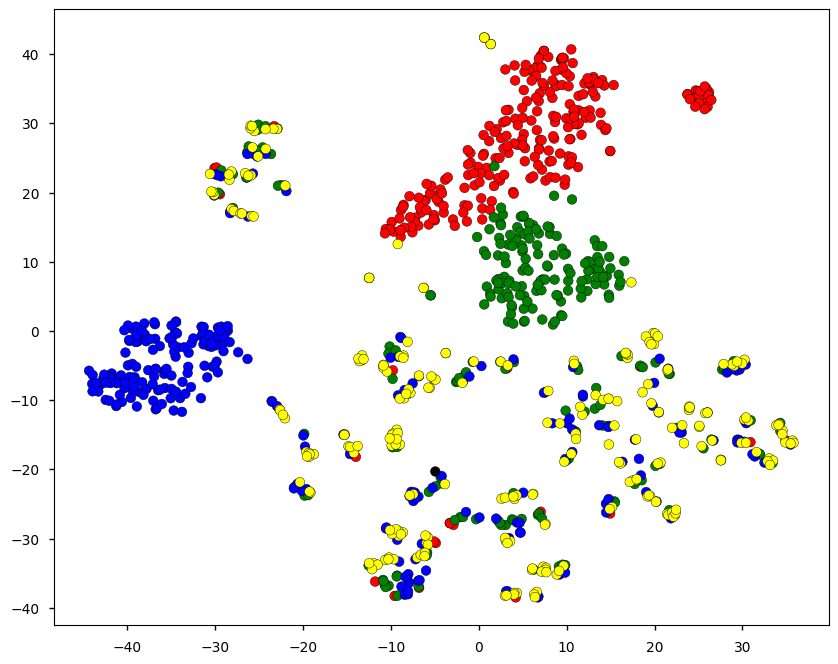

In [29]:
all_boxes_obs_test = np.concatenate([all_boxes_obs, obses])
all_boxes_actions_test = np.concatenate([all_boxes_actions, actions])
all_boxes_nobs_test = np.concatenate([all_boxes_nobs, next_obses])

dynamics_embedding_mean, std = network.select('dynamic_transformer')(all_boxes_obs_test, all_boxes_actions_test,
                                                                            all_boxes_nobs_test, train=False)

dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=GLOBAL_KEY, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(tsne[:, 0], tsne[:, 1], 
            edgecolors='black',
            c=colors + ['black'] * obses.shape[0])

# Cookie

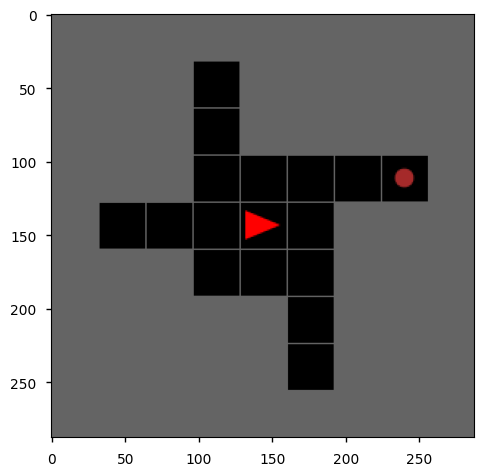

In [2]:
from envs.new_minigrid.cookie_modified import ModifiedCookieEnv
import gymnasium as gym
from utils.datasets import Dataset

env = gym.make("MiniGrid-Modified-Cookie-9x9-v0", disable_env_checker=True)
env = env.unwrapped
env.seed(seed=123)
obs, _ = env.reset()
plt.imshow(env.render())

whole_data_cookie = np.load("/home/m_bobrin/ZeroShotRL/envs/new_minigrid/collect_MiniGrid-Modified-Cookie-9x9-v0.npz", allow_pickle=True)['arr_0'][()]
whole_data_cookie['actions'] = whole_data_cookie['actions'][..., None]
whole_data_cookie['observations'] = whole_data_cookie['observations'].reshape(-1, env.max_steps, 243) # since 9x9x3
whole_data_cookie['next_observations'] = whole_data_cookie['next_observations'].reshape(-1, env.max_steps, 243)
whole_data_cookie['states'] = whole_data_cookie['states'].reshape(-1, env.max_steps, 243)
whole_data_cookie['next_states'] = whole_data_cookie['next_states'].reshape(-1, env.max_steps, 243)
whole_data_cookie = Dataset.create(**whole_data_cookie)

Take trajectories, which indicate at which room agent was. But this is not belief state yet. Then check whether cookie was present or not -> if not, then belief over other two rooms should increase.

In [78]:
import functools

def concatenate_dicts(dict1, dict2):
    return jax.tree.map(lambda x, y: jnp.concatenate([x, y]), dict1, dict2)

# FOR PLOTTING TSNE
# For rooms
checked_west_rooms_indxs = np.unique(np.where(whole_data_cookie['room_belief'] == 9)[0]) # checked West room -> 1001 (there can be an overlap -> 8, 8, 8, 8, 9)
checked_south_rooms_indxs = np.unique(np.where(whole_data_cookie['room_belief'] == 10)[0])
checked_east_rooms_indxs = np.unique(np.where(whole_data_cookie['room_belief'] == 12)[0])

trajs_checked_west_rooms = whole_data_cookie.get_subset(checked_west_rooms_indxs)
trajs_checked_south_rooms = whole_data_cookie.get_subset(checked_south_rooms_indxs)
trajs_checked_east_rooms = whole_data_cookie.get_subset(checked_east_rooms_indxs)

west_south_east_rooms = functools.reduce(concatenate_dicts, [trajs_checked_west_rooms, trajs_checked_south_rooms, trajs_checked_east_rooms])
style_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
rooms_colors = [style_colors[0]] * trajs_checked_west_rooms['observations'].shape[0] +\
    [style_colors[1]] * trajs_checked_south_rooms['observations'].shape[0] + [style_colors[2]] * trajs_checked_east_rooms['observations'].shape[0]
rooms_labels = ['west_room', 'south_room', 'east_room']

# For cookie pos
cookie_west_rooms_indxs = np.unique(np.where(whole_data_cookie['cookie_belief'] == 1)[0])
cookie_south_rooms_indxs = np.unique(np.where(whole_data_cookie['cookie_belief'] == 2)[0])
cookie_east_rooms_indxs = np.unique(np.where(whole_data_cookie['cookie_belief'] == 4)[0])

cookie_west_rooms = whole_data_cookie.get_subset(cookie_west_rooms_indxs)
cookie_south_rooms = whole_data_cookie.get_subset(cookie_south_rooms_indxs)
cookie_east_rooms = whole_data_cookie.get_subset(cookie_east_rooms_indxs)

west_south_east_cookies = functools.reduce(concatenate_dicts, [cookie_west_rooms, cookie_south_rooms, cookie_east_rooms])
cookie_colors = [style_colors[0]] * cookie_west_rooms['observations'].shape[0] +\
    [style_colors[1]] * cookie_south_rooms['observations'].shape[0] + [style_colors[2]] * cookie_east_rooms['observations'].shape[0]
cookie_labels = ['west_cookie'] * cookie_west_rooms['observations'].shape[0] +\
    ['south_cookie'] * cookie_south_rooms['observations'].shape[0] + ['east_cookie'] * cookie_east_rooms['observations'].shape[0]
    
# Rewards
non_zero_rewards_indx = np.where(sum(whole_data_cookie['rewards']) > 0)[0]
zero_rewards_indx = np.where(sum(whole_data_cookie['rewards']) == 0)[0]

non_zero_rewards = whole_data_cookie.get_subset(non_zero_rewards_indx)
zero_rewards = whole_data_cookie.get_subset(zero_rewards_indx)
rewards = functools.reduce(concatenate_dicts, [non_zero_rewards, zero_rewards])

rewards_colors = [style_colors[0]] * non_zero_rewards['observations'].shape[0] +\
    [style_colors[1]] * zero_rewards['observations'].shape[0]
rewards_labels = ['zero', 'nonzero']

# pprint(jax.tree.map(lambda x: x.shape, west_south_east_rooms))

In [10]:
from utils.transformer_nets import DynamicsTransformer, NextStatePrediction, LinearProbing
from utils.flax_utils import TrainState, ModuleDict
import optax
from sklearn.manifold import TSNE
from utils.networks import MLP

example_batch = whole_data_cookie.sample(1)

# Networks
next_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])
next_hidden_state_pred_def = NextStatePrediction(hidden_dims=(128, 128, 128), out_dim=example_batch['observations'].shape[-1])

dynamics_def = DynamicsTransformer(
    num_layers=2,
    num_heads=2,
    out_dim=128,
    action_dim=example_batch['actions'].shape[-1],
    causal=False,
    emb_dim=128,
    mlp_dim=256,
    dropout_rate=0.0,
    attention_dropout_rate=0.0,
    context_len=example_batch['observations'].shape[1]
)
# linear_prob_def = LinearProbing(hidden_dims=(32, 32, 32), out_dim=3)
reward_pred_def = MLP(hidden_dims=(128, 1))
key, init_rng = jax.random.split(GLOBAL_KEY)
network_tx = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=3e-4))

network_info = dict()
network_info.update(
                dynamic_transformer=(dynamics_def, (example_batch['observations'], example_batch['actions'],
                                                example_batch['observations'], True))
            )
network_info.update(
    next_state_pred=(next_state_pred_def, (example_batch['observations'], example_batch['actions'],
                                        jnp.zeros((1, example_batch['observations'].shape[1], dynamics_def.out_dim))))
)
network_info.update(
    reward_pred=(reward_pred_def, (jnp.zeros((1, 1, dynamics_def.out_dim), )))
)
network_info.update(
    next_hidden_state_pred = (next_hidden_state_pred_def, (example_batch['observations'], example_batch['actions'],
                                        jnp.zeros((1, example_batch['observations'].shape[1], dynamics_def.out_dim))))
)

# network_info.update(
#     linear_probing=(linear_prob_def, (jnp.zeros((1, dynamics_def.out_dim))))
# )
networks = {k: v[0] for k, v in network_info.items()}
network_args = {k: v[1] for k, v in network_info.items()}
network_def = ModuleDict(networks)
network_params = network_def.init(init_rng, **network_args)['params']
network = TrainState.create(network_def, network_params, tx=network_tx)

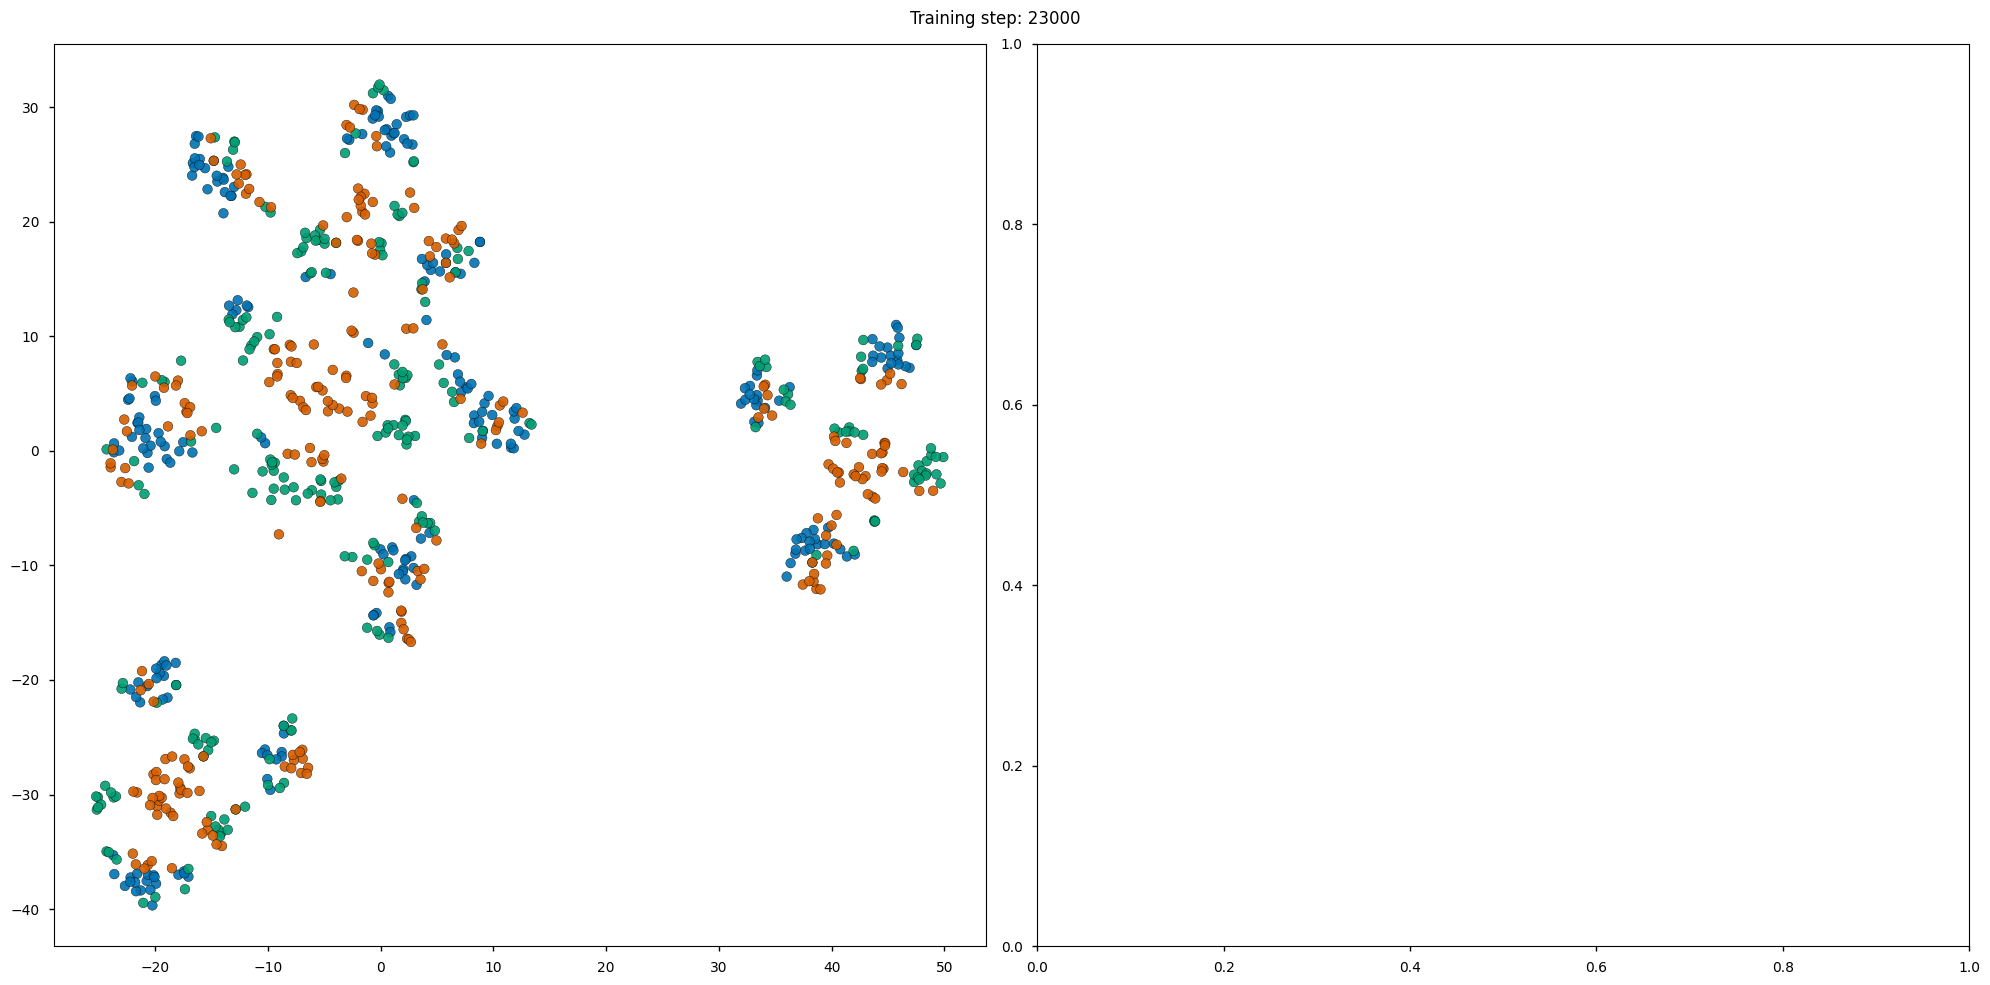

KeyboardInterrupt: 

In [11]:
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

def trans_encoder(agent, batch, grad_params, rng):
    dynamics_embedding_mean, dynamics_embedding_log_std = agent.select('dynamic_transformer')(batch['observations'], batch['actions'],
                                                                            batch['next_observations'], train=True, params=grad_params)
    dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=rng, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_log_std)
    dynamics_embedding = jnp.tile(dynamics_embedding[:, None], reps=(1, batch['next_observations'].shape[1], 1))
    next_state_pred = agent.select('next_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    reward_pred = agent.select('reward_pred')(dynamics_embedding, params=grad_params)
    next_hidden_state_pred = agent.select('next_hidden_state_pred')(batch['observations'], batch['actions'], dynamics_embedding, params=grad_params)
    next_hidden_state_loss = optax.squared_error(next_hidden_state_pred, batch['next_states']).mean()
    rew_loss = (0.5 * (reward_pred - batch['rewards'][..., None])**2).mean()
    loss = optax.squared_error(next_state_pred, batch['next_observations']).mean()
    # kl_loss = -0.5 * (1 + dynamics_embedding_log_std - dynamics_embedding_mean**2 - jnp.exp(dynamics_embedding_log_std)).mean()
    return loss + 10 * rew_loss + next_hidden_state_loss, {"context_embedding_loss": loss}

@jax.jit
def update_belief_encoder(agent, batch, rng):
    def loss_fn(grad_params):
        return trans_encoder(agent, batch, grad_params, rng)
    
    agent, info = agent.apply_loss_fn(loss_fn)
    return agent, info

# train_indices, test_indices = train_test_split(
#     np.arange(labels.shape[0]),
#     test_size=0.4,
#     random_state=42,
#     stratify=labels
# )

pbar = tqdm(range(50_000))
for i in pbar:
    batch = whole_data_cookie.sample(128)
    update_key = jax.random.fold_in(GLOBAL_KEY, i)
    network, info = update_belief_encoder(network, batch, update_key)
    
    if i % 1000 == 0:
        clear_output()
        dynamics_embedding_mean, std = network.select('dynamic_transformer')(west_south_east_cookies['observations'], west_south_east_cookies['actions'],
                                                                            west_south_east_cookies['next_observations'], train=False)
        dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(std)
        
        tsne = TSNE(random_state=42).fit_transform(dynamics_embedding)
        fig, axs = plt.subplots(figsize=(20, 10), nrows=1, ncols=2)
        axs[0].scatter(tsne[:, 0], tsne[:, 1], 
                    edgecolors='black',
                    c=cookie_colors,
                    alpha=0.9)
        
        # # dynamics_embedding_mean, dynamics_embedding_log_std = network.select('dynamic_transformer')(rand_box_obs_2, rand_box_actions_2,
        # #                                                                     rand_box_nobs_2, train=False)
        # # dynamics_embedding = dynamics_embedding_mean + jax.random.normal(key=update_key, shape=dynamics_embedding_mean.shape) * jnp.exp(dynamics_embedding_log_std)
        # logistic_reg = LogisticRegression(penalty='l2', solver='liblinear', max_iter=500).fit(dynamics_embedding[train_indices], labels[train_indices])
        # belief_preds = logistic_reg.predict_proba(dynamics_embedding[test_indices])
        # # linear_reg = LinearRegression().fit(dynamics_embedding[train_indices], labels[train_indices])
        # # belief_preds = linear_reg.predict(dynamics_embedding[test_indices])
        # # # belief_preds = jax.nn.softmax(network.select("linear_probing")(dynamics_embedding), -1)
        # mean_probs = belief_preds.mean(axis=0)
        # std_probs = belief_preds.std(axis=0)

        # axs[1].bar(range(4), mean_probs, yerr=std_probs, 
        #         color=['red', 'green', 'blue', 'yellow'], capsize=5)
        # axs[1].set_xticks(range(4), [f'Class {i}' for i in range(4)])
        # axs[1].set_ylim(0, 1)
        
        fig.suptitle(f"Training step: {i}")
        plt.tight_layout()
        display(fig)
        plt.close(fig)